## Tutorial 1: Training classifier for Chest Xray dataset.

### Introduction

This is a quick walkthrough notebook to demonstrate how to train MobileNetV3 classification model on Chest Xray Dataset using PyTorch! At the end of this tutorial, you are expected to get `pneumonia_final.pt` file.

### Table of contents

- [Imports](#imports)
- [Load Chest Xray dataset](#load-Chest-Xray-dataset)
- [Define dataloaders](#define-dataloaders)
- [Define model and loss](#define-model-and-loss)
- [Start training loop](#start-training-loop)

#### Imports

In [1]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.mobile_optimizer import optimize_for_mobile
from farabio.data.biodatasets import *
from farabio.models.classification import *

#### Load Chest Xray dataset

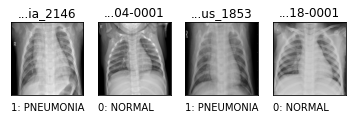

In [2]:
_path = "/home/data/07_SSD4TB/public-datasets/chest-xray"

train_dataset = ChestXrayDataset(root=_path, download=False, mode="train", show=True)
valid_dataset = ChestXrayDataset(root=_path, download=False, mode="val", show=False)

#### Define dataloaders

In [3]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)

#### Define model and loss

In [4]:
model = mobilenet_v3_small(n_classes=2)
device = "cuda:1"
model.to(torch.device(device))
print("model is ready!")

criterion = nn.CrossEntropyLoss()                   
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

def accuracy(preds, labels):
    preds = torch.exp(preds)
    top_p,top_class = preds.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

model is ready!


#### Start training loop

In [5]:
epochs = 15
val_loss_min = np.Inf
model_name = 'pneumonia_final.pt'

for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    
    model.train()
    for images,labels,fnames in tqdm(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(preds, labels)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    model.eval()
    with torch.no_grad():
        for images,labels,fnames in tqdm(valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            val_acc += accuracy(preds, labels)

        avg_val_loss = val_loss / len(valid_loader)
        avg_val_acc = val_acc / len(valid_loader)

    schedular.step(avg_val_loss)

    print("Epoch : {} \ntrain_loss : {:.6f}, \tTrain_acc : {:.6f}, \nVal_loss : {:.6f}, \tVal_acc : {:.6f}".format(epoch + 1,
                                                                                                                   avg_train_loss, avg_train_acc,
                                                                                                                   avg_val_loss, avg_val_acc))

    if avg_val_loss <= val_loss_min:
        print('Validation loss decreased from ({:.6f} --> {:.6f}).\nSaving model ...'.format(val_loss_min, avg_val_loss))
        torch.save(model.state_dict(), model_name)
        val_loss_min = avg_val_loss
        
print("training finished!")

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.26it/s]


Epoch : 1 
train_loss : 0.225839, 	Train_acc : 0.908167, 
Val_loss : 2.399726, 	Val_acc : 0.500000
Validation loss decreased from (inf --> 2.399726).
Saving model ...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.35it/s]


Epoch : 2 
train_loss : 0.136575, 	Train_acc : 0.949386, 
Val_loss : 4.680121, 	Val_acc : 0.562500


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.11it/s]


Epoch : 3 
train_loss : 0.086038, 	Train_acc : 0.970475, 
Val_loss : 1.058345, 	Val_acc : 0.625000
Validation loss decreased from (2.399726 --> 1.058345).
Saving model ...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.60it/s]


Epoch : 4 
train_loss : 0.082089, 	Train_acc : 0.970284, 
Val_loss : 0.782010, 	Val_acc : 0.625000
Validation loss decreased from (1.058345 --> 0.782010).
Saving model ...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.49it/s]


Epoch : 5 
train_loss : 0.067029, 	Train_acc : 0.977186, 
Val_loss : 2.869095, 	Val_acc : 0.625000


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.43it/s]


Epoch : 6 
train_loss : 0.042642, 	Train_acc : 0.986771, 
Val_loss : 0.759150, 	Val_acc : 0.812500
Validation loss decreased from (0.782010 --> 0.759150).
Saving model ...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.76it/s]


Epoch : 7 
train_loss : 0.050135, 	Train_acc : 0.982745, 
Val_loss : 0.487491, 	Val_acc : 0.812500
Validation loss decreased from (0.759150 --> 0.487491).
Saving model ...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.36it/s]


Epoch : 8 
train_loss : 0.040694, 	Train_acc : 0.987155, 
Val_loss : 1.309484, 	Val_acc : 0.562500


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s]


Epoch : 9 
train_loss : 0.043130, 	Train_acc : 0.983896, 
Val_loss : 2.821720, 	Val_acc : 0.562500


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.26it/s]


Epoch : 10 
train_loss : 0.032577, 	Train_acc : 0.989456, 
Val_loss : 0.974484, 	Val_acc : 0.687500


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.53it/s]


Epoch : 11 
train_loss : 0.022331, 	Train_acc : 0.991181, 
Val_loss : 1.673677, 	Val_acc : 0.750000


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.29it/s]


Epoch : 12 
train_loss : 0.006696, 	Train_acc : 0.997124, 
Val_loss : 1.758937, 	Val_acc : 0.750000


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch : 13 
train_loss : 0.002338, 	Train_acc : 0.999425, 
Val_loss : 1.841676, 	Val_acc : 0.750000


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.37it/s]


Epoch : 14 
train_loss : 0.000901, 	Train_acc : 0.999808, 
Val_loss : 1.898375, 	Val_acc : 0.750000


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.43it/s]

Epoch : 15 
train_loss : 0.000641, 	Train_acc : 1.000000, 
Val_loss : 2.010077, 	Val_acc : 0.750000
training finished!
